<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

---

**Цель работы**  
Создать модель прогнозирования количества заказов такси на следующий час для компании «Чётенькое такси». Цель — оптимизировать распределение водителей в периоды пиковой нагрузки, минимизируя простои и повышая удовлетворенность клиентов. Качество прогноза должно быть оценено по метрике RMSE ≤ 48 на тестовой выборке.

**Описание данных**  
Для выполнения проекта использованы исторические данные о заказах такси, собранные в аэропортах. Датасет хранится в файле `/datasets/taxi.csv` и содержит:  
- **`datetime`** — временная метка заказа.  
- **`num_orders`** — количество заказов за соответствующий момент времени.  

Данные требуют предварительной агрегации:  
- **Ресемплирование**: Данные будут сгруппированы по одному часу, чтобы получить ежечасное количество заказов.  
- **Предобработка**: Устранение пропусков, анализ аномалий и создание дополнительных признаков для улучшения прогноза.  

**План выполнения проекта**  
Проект будет реализован в следующей последовательности этапов:  

1. **Загрузка и предобработка данных**  
   - Загрузка датасета.  
   - Ресемплирование данных по часам с агрегацией значений `num_orders`.  
   - Изучение структуры датасета и первичный анализ.  

2. **Анализ временных рядов**  
   - Визуализация динамики заказов для выявления трендов и сезонных паттернов.  

3. **Генерация признаков**  
   - Создание временных признаков: например час, день недели, месяц.  
   - Лаговые переменные.  
   - Скользящие статистики.  

4. **Обучение моделей** 
   - Подбор гиперпараметров через кросс-валидацию.  
   - Разделение данных на обучающую (90%) и тестовую (10%) выборки.  

5. **Оценка и интерпретация результатов**  
   - Вычисление RMSE для лучшей модели на тестовой выборке.   
   - Выбор лучшей модели и интерпретация её предсказаний.  

6. **Бизнес-рекомендации**  
   - Формулировка практических советов для компании.

## Подготовка

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

RANDOM_STATE = 42

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# Загрузка данных
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

Сортируем индексы в датасете.

In [5]:
df = df.sort_index()

Ресемплируем данные по часам, с агрегацией значений `num_orders`,

In [6]:
df = df.resample('1H').sum()

In [7]:
# Функция для ознакомления с таблицами
def first_check(data, dataset_name=""):
    # Печатаем название датасета
    if dataset_name:
        print(f"Анализ датасета: {dataset_name}")
    else:
        print("Анализ датасета")
    print("=" * 40 + "\n")
    
    # Первые и последние строки
    print("Первые 5 строк:")
    display(data.head())
    print("\nПоследние 5 строк:")
    display(data.tail())
    
    # Информация о данных
    print("\nИнформация о данных:")
    display(data.info())
    
    # Описательная статистика
    print("\nОписательная статистика:")
    display(data.describe(include='all').T)

    # Информация о налиичии пропусоков
    print('\nКоличество пропусков:')
    print(data.isna().sum())

In [8]:
first_check(df)

Анализ датасета

Первые 5 строк:


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43



Последние 5 строк:


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None


Описательная статистика:


,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0



Количество пропусков:
num_orders    0
dtype: int64


- Размер датасета ресемплирования данных по часам, с агрегацией значений имеет `4416` строк.
- Имеем данны за промежуток с `2018-03-01 00:00:00` по `2018-08-31 23:00:00`.
- При первичном анализе пропущенных значений не обнаружено.

## Анализ

Построим график количества заказов за весь период, чтобы визуально оценить тренды и сезонность:

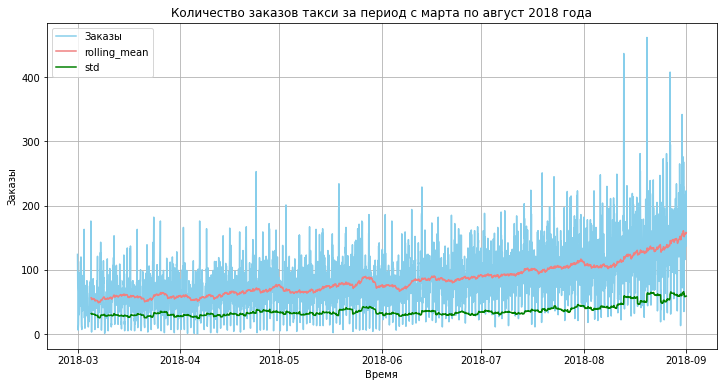

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df['num_orders'], label='Заказы', color='skyblue')
plt.plot(df['num_orders'].rolling(100).mean(), label='rolling_mean', color='lightcoral')
plt.plot(df['num_orders'].rolling(100).std(), label='std', color='green')
plt.title('Количество заказов такси за период с марта по август 2018 года')
plt.xlabel('Время')
plt.ylabel('Заказы')
plt.grid(True)
plt.legend()
plt.show()

- Среднее количество заказов такси стабильно растёт на протяжении всего периода. В начале марта среднее значение находится на уровне около 70–80 заказов, а к концу августа превышает 150 заказов.
- На графике заметны отдельные резкие всплески (столбики выше 200, 300 и 400 заказов), что может быть связано с праздниками или погодными условиями.

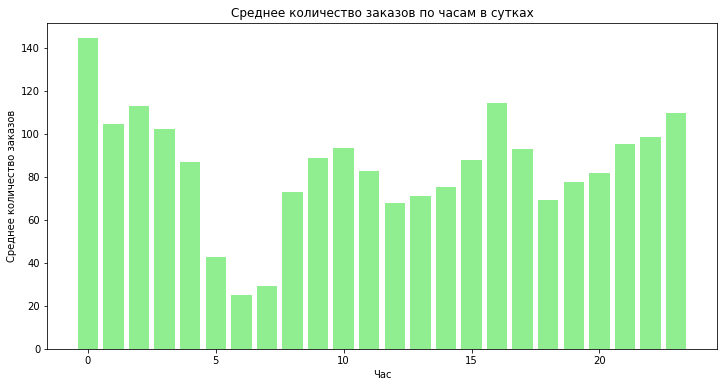

In [10]:
plt.figure(figsize=(12, 6))
plt.bar(df.groupby(df.index.hour)['num_orders'].mean().index,
        df.groupby(df.index.hour)['num_orders'].mean().values, color='lightgreen')
plt.title('Среднее количество заказов по часам в сутках')
plt.xlabel('Час')
plt.ylabel('Среднее количество заказов')
plt.show()

Суточный цикл спроса на такси выражен очень чётко: максимумы приходятся на полночь и вечер, минимумы — на раннее утро.

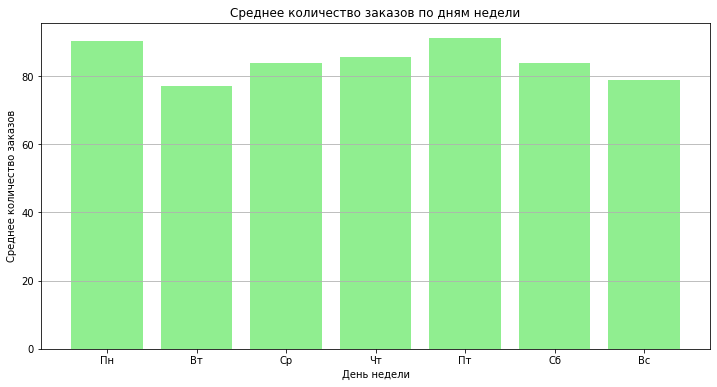

In [11]:
days_of_week = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
plt.figure(figsize=(12, 6))
plt.bar(days_of_week, df.groupby(df.index.dayofweek)['num_orders'].mean().values, color='lightgreen')
plt.title('Среднее количество заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее количество заказов')
plt.grid(axis='y')
plt.show()

Существует выраженная недельная сезонность спроса на такси. Наибольший спрос наблюдается в пятницу и понедельник, наименьший — во вторник и воскресенье.

Для анализа трендов и сезонности воспользуемся функцией seasonal_decompose из библиотеки statsmodels.

In [12]:
# Применяем seasonal_decompose
decomposed = seasonal_decompose(df['num_orders'], period=24)

Указываем сезонность 24 часов, так как данные ресемплированны по часам.

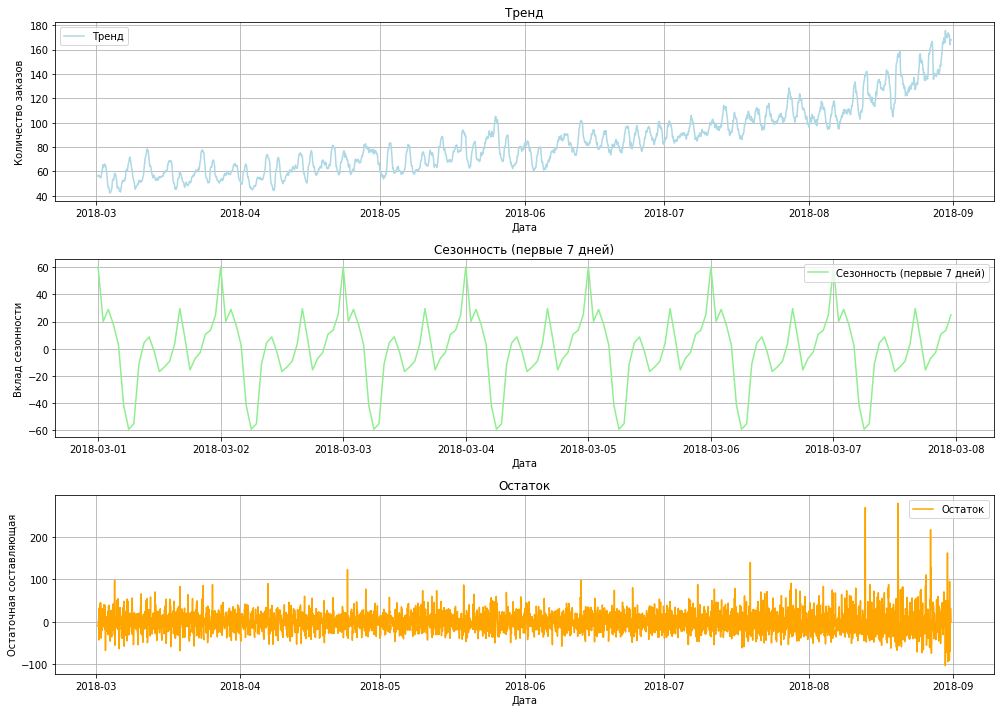

In [13]:
# Создаем график с тремя подграфиками
plt.figure(figsize=(14, 10))

# Тренд
plt.subplot(3, 1, 1)
plt.plot(decomposed.trend, label='Тренд', color='lightblue')
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.legend()

# Сезонность
plt.subplot(3, 1, 2)
plt.plot(decomposed.seasonal[:24*7], label='Сезонность (первые 7 дней)', color='lightgreen')  # Показываем первые 7 дней
plt.title('Сезонность (первые 7 дней)')
plt.xlabel('Дата')
plt.ylabel('Вклад сезонности')
plt.grid(True)
plt.legend()

# Остаток
plt.subplot(3, 1, 3)
plt.plot(decomposed.resid, label='Остаток', color='orange')
plt.title('Остаток')
plt.xlabel('Дата')
plt.ylabel('Остаточная составляющая')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

- Тренд: Наблюдается стабильный рост в количестве заказов такси с марта по август 2018 года. Это может быть связано с увеличением числа пользователей сервиса.
- Сезонность: График показывает повторяющийся паттерн сезонности в течение первых 7 дней периода. Пики наблюдаются примерно в вечернее время и спадают ближе к утру.

## Обучение

Создадим новые признаки, которые помогут модели машинного обучения лучше понять структуру данных.

Создаем календарные признаки.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_std'] = df['num_orders'].shift().rolling(rolling_mean_size).std()
    return data

In [15]:
df_mf = make_features(df, 24, 100)

Удаленим строки с пропусками после создания лагов и скользящих статистик.

In [16]:
# Удаление строк с пропусками после создания лагов и скользящих статистик
df_mf = df_mf.dropna()

Выведем первые 5 строк после генерации признаков.

In [17]:
# Проверка первых строк нового DataFrame
print("Первые 5 строк после генерации признаков:")
df_mf.head()

Первые 5 строк после генерации признаков:


,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,2018,3,5,0,4,51.0,32.0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46,31.750740
2018-03-05 05:00:00,16,2018,3,5,0,5,34.0,51.0,32.0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56,31.085519
2018-03-05 06:00:00,3,2018,3,5,0,6,16.0,34.0,51.0,32.0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87,31.191055
2018-03-05 07:00:00,14,2018,3,5,0,7,3.0,16.0,34.0,51.0,32.0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19,31.574729
2018-03-05 08:00:00,31,2018,3,5,0,8,14.0,3.0,16.0,34.0,51.0,32.0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67,31.805614


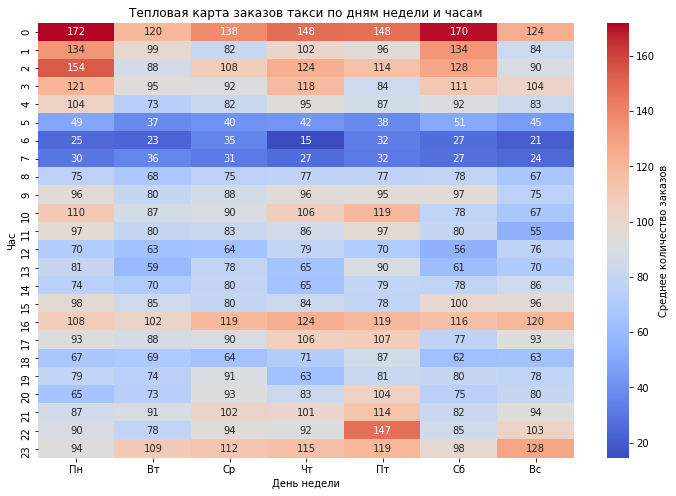

In [18]:
heatmap_data = df_mf.groupby(['hour', 'dayofweek'])['num_orders'].mean().unstack()
heatmap_data.columns = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

# Строим тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='coolwarm', cbar_kws={'label': 'Среднее количество заказов'})
plt.title('Тепловая карта заказов такси по дням недели и часам')
plt.xlabel('День недели')
plt.ylabel('Час')
plt.show()

- Ночное время: Наибольшее количество заказов приходится на ночное время (особенно с 22:00 до 2:00), что может быть связано с прилетом поздних рейсов.
- Утренние часы: Наименьшее количество заказов наблюдается в ранние утренние часы (с 5:00 до 7:00).
- Дневное время: В дневное время количество заказов стабильно, но несколько ниже, чем ночью.
- Пик в пятницу ночью: В пятницу ночью (особенно с 23:00 до 01:00) наблюдается наиболее высокий спрос на такси.
- Выходные дни: В целом в выходные дни спрос на такси более равномерный в течение суток, чем в будние дни.
- Наименьший спрос утром в воскресенье.

Выделим тренировочную и тестовую выборку.

In [19]:
# Выделение признаков (X) и целевой переменной (y)
X = df_mf.drop(columns='num_orders', axis=1)
y = df_mf['num_orders']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

Проверим размерность новых датасетов.

In [20]:
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(3884, 31)

(3884,)

(432, 31)

(432,)

In [21]:
# Создадим список с названиями признаков
num_columns = X_train.columns.tolist()  # Числовые признаки

In [22]:
# Общая подготовка данных
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [23]:
# Итоговый пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [24]:
# Словарь с моделями и их гиперпараметрами для RandomizedSearchCV
param_grid = [
    # Словарь для модели DecisionTreeRegressor()
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [5, 10, 15],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    
    # Словарь для модели CatBoostRegressor() 
    {
        'model': [CatBoostRegressor(verbose=0, random_state=RANDOM_STATE)],
        'model__depth': [4, 6, 8],
        'model__iterations': [300, 500, 1000],
        'preprocessor__num': [StandardScaler(), 'passthrough']   
    },

    # Словарь для модели LinearRegression()
    {
        'model': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },
]

Использование стандартной кросс-валидации (например KFold) для временных рядов может привести к утечке данных. Для предотвращения этой ошибки используют TimeSeriesSplit — этот метод разделяет данные с сохранением хронологического порядка.

In [25]:
tscv = TimeSeriesSplit(n_splits=3)

In [26]:
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_iter=10,  # Количество случайных комбинаций
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['year',
                                                                                'month',
                                                                                'day',
                                                                                'dayofweek',
                                                                                'hour',
                                                                                'lag_1',
                                     

## Тестирование

In [27]:
best_params = random_search.best_params_
print(f'Лучшие параметры модели:')
best_params

Лучшие параметры модели:


{'preprocessor__num': StandardScaler(),
 'model__iterations': 1000,
 'model__depth': 6,
 'model': <catboost.core.CatBoostRegressor at 0x7f56881c4370>}

In [28]:
best_rmse = -random_search.best_score_
print(f'Метрика RMSE, для модели CatBoostRegressor на кросс-валидации: {best_rmse:.2f}')

Метрика RMSE, для модели CatBoostRegressor на кросс-валидации: 26.16


Значение метрики RMSE на кросс-валидации меньше 48, что подходит под условие задачи.

In [29]:
best_model = random_search.best_estimator_

In [30]:
y_pred_best = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"RMSE на тестовой выборке для лучшей модели: {test_rmse:.2f}")

RMSE на тестовой выборке для лучшей модели: 39.43


Значение метрики RMSE на тестовой выборке меньше 48, что подходит под условие задачи.

Сравним прогноз модели с фактическими данными, чтобы оценить качество визуально.

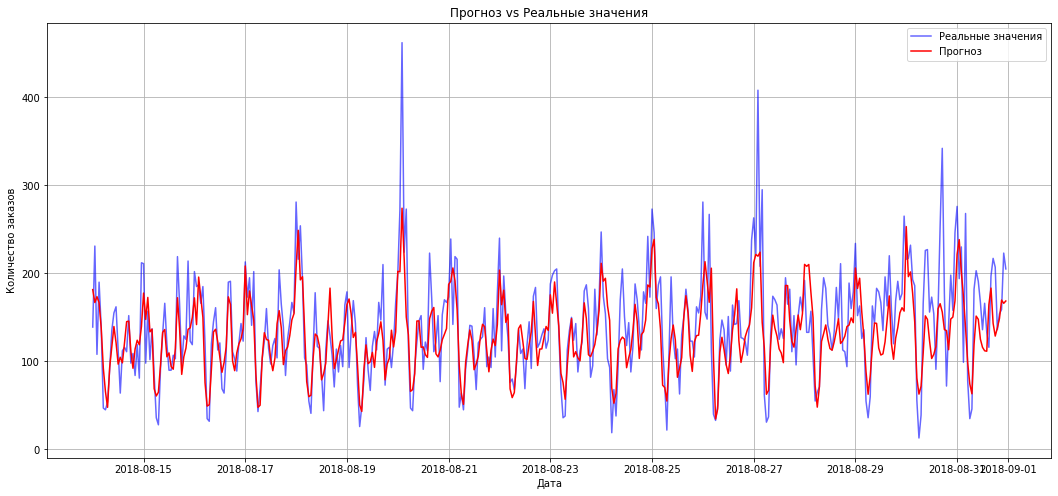

In [31]:
plt.figure(figsize=(18, 8))
plt.plot(y_test.index, y_test, label='Реальные значения', color='blue', alpha=0.6)
plt.plot(y_test.index, y_pred_best, label='Прогноз', color='red')
plt.title('Прогноз vs Реальные значения')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid(True)
plt.show()

- График в целом отражает изменения количества заказов, модель улавливает основные колебания спроса.
- На некоторых участках графика видно, что прогноз отстает от реальных данных.
- В целом, прогноз достаточно точно предсказывает количество заказов.

## Общие выводы

**1. Описание задачи**
- **Проблема**: Прогнозирование количества заказов такси на следующий час для минимизации простоев водителей.
- **Бизнес-цель**: Оптимизация распределения водителей в пиковые периоды, сокращение времени ожидания клиентов и снижение операционных издержек.
- **Данные**:
  - Источник: Исторические данные о заказах такси в аэропортах (файл `taxi.csv`).
  - Типы: Временной ряд с агрегацией по часам (столбцы: `datetime`, `num_orders`).
  - Размер: 4416 строк (с марта по август 2018 года).

**2. Ключевые этапы работы**
- **Предобработка данных**:
  - Ресемплирование по часам (суммирование заказов).
  - Генерация признаков:
    - Временные метки (`hour`, `dayofweek`, `month`).
    - Лаги (`lag_1`–`lag_24`).
    - Скользящее среднее и стандартное отклонение за 100 часов.
  - Удаление пропусков.

- **Модели**:
  - **CatBoostRegressor**.
  - **DecisionTreeRegressor**.
  - **LinearRegression**.

- **Оценка качества**:
  - Метрика **RMSE** (требование ≤ 48).
  - Подбор гиперпараметров через `RandomizedSearchCV`,  временная кросс-валидация TimeSeriesSplit (3 фолдов).

**3. Основные результаты**
- **Метрики**:
  - Лучшая модель: **CatBoostRegressor** (RMSE на тесте = **39,43**).
  - Кросс-валидация: RMSE = **26,16** (подтверждает стабильность модели).

- **Закономерности**:
  - **Ночные пики**: Максимальный спрос с 22:00 до 2:00, особенно в пятницу.
  - **Утренние минимумы**: Наименьшее количество заказов с 5:00 до 7:00.
  - **Пятничный спрос**: Высокая активность ночью (23:00–01:00).
  - **Выходные дни**: Более равномерное распределение заказов, но с пиком в пятницу вечером.

**4. Рекомендации**
- **Для бизнеса**:
  - Увеличивать количество водителей в **ночное время** (22:00–2:00) и **пятничные вечера**.
  - Внедрить автоматические уведомления водителям за 1–2 часа до пиковых периодов.